<a href="https://colab.research.google.com/github/HannaRF/Semantic-Segmentation/blob/main/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#
 **Homework 2 - Semantic Segmentation**

Objective: Implement a U-Net Network for semantic segmentation.



Dataset:

<figure>
<center>
<img src= 'https://raw.githubusercontent.com/mabelortega/DL_Semantic_Segmentation/main/Figures/drawing1.png'/>
</figure>

You must train the network model by using these images [https://drive.google.com/file/d/1TU2nTVGS2932hRs1u-ma4r3vmgqHRbMO/view?usp=sharing]. Image_Train.tif and Reference_Train.tif images and it must be evaluated on Image_Test.tif and Reference_Test.tif images. You can use this notebook that contains some basic functions.

Experimental Protocol

Load the input data
1.     Load the images provided from 2D Semantic Labeling-Vaihingen dataset using the function load_tiff_image(image) and normalize the data into the range [0,1] using the function normalization (image)

Train the FCN model
2.     To train the FCN model you need patches as input. You must extract patches of size w-by-w-by-c pixels from Image_Train and patches with size w-by-w from Reference_Train. The number of patches and the w must be chosen based on the input size of network.

3.     Split randomly the training patches into two sets: Training (80%) and validation (20%).

4.     Convert the patches of the Reference image into one-hot encoding base on the number of classes. Hint: Use the function tf.keras.utils.to_categorical.

5.     Create the function of the U-Net model - Using skip connections: Hint: use tensorflow.keras.layers.concatenate

6.     For training, use the weighted_categorical_crossentropy as a loss function. Hint: To compute the weights you must count the number of pixels of each class and apply the formula: w_i = #total_pixels / #pixels_of_class_i



7.     Train the model using Train_model() function, which has as input the training and validation patches. You must the best model adding the early stop strategy with patience equal to 10.

8.     Extract patches from the test images and test the model using Test(model, patch_test).

9.     Reconstruct the prediction (whole test image)

The report must present the classification results as label images, and report accuracy metrics (overall and average class accuracies, F1-score) you also must change the size of the extracted patches to compare the results (32x32, 64x64, 128x128)

# **Import the libraries**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from osgeo import ogr, gdal
from sklearn.utils import shuffle
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config

np_config.enable_numpy_behavior()

# **Define the functions**

In [ ]:
def load_tiff_image(image):
  print (image)
  gdal_header = gdal.Open(image)
  img = gdal_header.ReadAsArray()
  return img

def normalization(image):
  image_reshaped = image.reshape((image.shape[0]*image.shape[1]),image.shape[2])
  scaler = MinMaxScaler(feature_range=(0,1))
  scaler = scaler.fit(image_reshaped)
  image_normalized_ = scaler.fit_transform(image_reshaped)
  image_normalized = image_normalized_.reshape(image.shape[0],image.shape[1],image.shape[2])
  return image_normalized

# def extract_patches(image, reference, patch_size, stride):
#   pass

# def unet(input_shape, n_classes):
#   input_img = Input(input_shape)
#   # You must complete the U-Net architecture
#   output = Conv2D(n_classes,(1,1), activation = 'softmax')(merged)
#   return Model(inputs = input_img, outputs = output, name='U-Net')

def weighted_categorical_crossentropy(weights):
        """
        A weighted version of keras.objectives.categorical_crossentropy

        Variables:
            weights: numpy array of shape (C,) where C is the number of classes

        Usage:
            weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
            loss = weighted_categorical_crossentropy(weights)
            model.compile(loss=loss,optimizer='adam')
        """
        weights = K.variable(weights)
        def loss(y_true, y_pred):
            # scale predictions so that the class probas of each sample sum to 1
            y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
            # clip to prevent NaN's and Inf's

            y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
            loss = y_true * K.log(y_pred) + (1-y_true) * K.log(1-y_pred)
            loss = loss * weights
            loss = - K.mean(loss, -1)
            return loss
        return loss

def Train_model(net, patches_train, patches_tr_lb_h, patches_val, patches_val_lb_h, batch_size, epochs):
  patience = 0
  old_loss_val = 10

  print('Start training.. ')
  for epoch in range(epochs):

    #print('epoch' + str(epoch))

    loss_tr = np.zeros((1 , 2))
    loss_val = np.zeros((1 , 2))
    # Computing the number of batchs
    n_batchs_tr = patches_train.shape[0]//batch_size
    # Random shuffle the data
    patches_train , patches_tr_lb_h = shuffle(patches_train, patches_tr_lb_h , random_state = 0)

    # Training the network per batch
    for  batch in range(n_batchs_tr):
      #print('batch' + str(batch))

      x_train_b = patches_train[batch * batch_size : (batch + 1) * batch_size , : , :]
      y_train_h_b = patches_tr_lb_h[batch * batch_size : (batch + 1) * batch_size , :, :]
      loss_tr = loss_tr + net.train_on_batch(x_train_b , y_train_h_b)

    # Training loss
    loss_tr = loss_tr/n_batchs_tr
    print("%d [Training loss: %f , Train acc.: %.2f%%]" %(epoch , loss_tr[0 , 0], 100*loss_tr[0 , 1]))

    # Computing the number of batchs
    n_batchs_val = patches_val.shape[0]//batch_size

    # Evaluating the model in the validation set
    for  batch in range(n_batchs_val):
      x_val_b = patches_val[batch * batch_size : (batch + 1) * batch_size , : , :]
      y_val_h_b = patches_val_lb_h[batch * batch_size : (batch + 1) * batch_size , :, :]
      loss_val = loss_val + net.test_on_batch(x_val_b , y_val_h_b)

    # validation loss
    loss_val = loss_val/n_batchs_val
    print("%d [Validation loss: %f , Validation acc.: %.2f%%]" %(epoch , loss_val[0 , 0], 100*loss_val[0 , 1]))

    # Add early stopping

    if old_loss_val < loss_val[0,0]: patience+=1
    else: patience=0

    old_loss_val = loss_val[0,0]

    if patience == 10: break


def Test(model, patch_test):
  result = model.predict(patch_test)
  predicted_class = np.argmax(result, axis=-1)
  return predicted_class

def compute_metrics(true_labels, predicted_labels):
  accuracy = 100*accuracy_score(true_labels, predicted_labels)
  f1score = 100*f1_score(true_labels, predicted_labels, average=None)
  recall = 100*recall_score(true_labels, predicted_labels, average=None)
  precision = 100*precision_score(true_labels, predicted_labels, average=None)
  return accuracy, f1score, recall, precision


# 1. Load the input data

In [ ]:
!gdown 1TU2nTVGS2932hRs1u-ma4r3vmgqHRbMO
!unrar e images.rar

Downloading...
From: https://drive.google.com/uc?id=1TU2nTVGS2932hRs1u-ma4r3vmgqHRbMO
To: /content/images.rar
100% 24.9M/24.9M [00:01<00:00, 21.8MB/s]
^C

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from images.rar


Would you like to replace the existing file Image_Test.tif
21789756 bytes, modified on 2013-11-01 11:15
with a new one
21789756 bytes, modified on 2013-11-01 11:15

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit 
User break

User break


In [ ]:
train_ref_img = load_tiff_image('Reference_Train.tif')
train_img = load_tiff_image('Image_Train.tif')
test_ref_img = load_tiff_image('Reference_Test.tif')
test_img = load_tiff_image('Image_Test.tif')

train_ref_img = normalization(train_ref_img)
train_img = normalization(train_img)
test_ref_img = normalization(test_ref_img)
test_img = normalization(test_img)

Reference_Train.tif
Image_Train.tif
Reference_Test.tif
Image_Test.tif


In [ ]:
print(train_ref_img.shape)
print(train_img.shape)
print(test_ref_img.shape)
print(test_img.shape)

(3, 2565, 1919)
(3, 2565, 1919)
(3, 2558, 2818)
(3, 2558, 2818)


# 2. Categorize and Extract Patches

In [ ]:
def extract_patches(Image, Reference, patch_size, stride, num_classes):
  enc = LabelEncoder()
  Reference = np.array(tf.image.rgb_to_grayscale(np.transpose(Reference, (1, 2, 0))))
  Reference = enc.fit_transform(Reference.flatten()).reshape(Reference.shape)
  Reference = to_categorical(Reference)
  Reference = tf.convert_to_tensor(Reference.reshape((1,) + Reference.shape), dtype="float64")

  Image = np.transpose(Image, (1, 2, 0))
  Image = tf.convert_to_tensor(Image.reshape((1,) + Image.shape), dtype="float64")

  Image_patches = tf.image.extract_patches(Image, [1, patch_size, patch_size, 1], [1,stride,stride,1], [1,1,1,1], "VALID")
  Image_ref_patches = tf.image.extract_patches(Reference, [1, patch_size, patch_size, 1], [1,stride,stride,1], [1,1,1,1], "VALID")

  return Image_patches, Image_ref_patches

In [ ]:
patch_size = 128
stride = 128
num_classes = 5
patches_Image, patches_Reference = extract_patches(train_img, train_ref_img, patch_size, stride, num_classes)

In [ ]:
patches_Image.shape

TensorShape([1, 20, 14, 49152])

# 3. Split Patches

In [ ]:
import random

# Define o intervalo de valores para x e y
x_range = range(20)  # 0 a 80
y_range = range(14)  # 0 a 59

# Gera todas as combinações possíveis de (x, y)
all_combinations = [(x, y) for x in x_range for y in y_range]

# Embaralha as combinações aleatoriamente
random.shuffle(all_combinations)

# Agora você pode amostrar as tuplas de (x, y) sem repetição
sample_size = int(0.8*(20*14))  # Tamanho da amostra desejada
sample_train = all_combinations[:sample_size]
sample_val = all_combinations[sample_size:]

# Criando os conjuntos de treino e validação
train_patches =  np.array([patches_Image[:,tupla[0],tupla[1],:] for tupla in sample_train])
train_ref_patches =  np.array([patches_Reference[:,tupla[0],tupla[1],:] for tupla in sample_train])
val_patches =  np.array([patches_Image[:,tupla[0],tupla[1],:] for tupla in sample_val])
val_ref_patches =  np.array([patches_Reference[:,tupla[0],tupla[1],:] for tupla in sample_val])

# Modificando a dimensão deles para encaixar na rede
train_patches = np.transpose(train_patches, (1,0,2)).squeeze().reshape(224,128,128,3)
train_ref_patches = np.transpose(train_ref_patches, (1,0,2)).squeeze().reshape(224,128,128,5)
val_patches = np.transpose(val_patches, (1,0,2)).squeeze().reshape(56,128,128,3)
val_ref_patches = np.transpose(val_ref_patches, (1,0,2)).squeeze().reshape(56,128,128,5)

# Convertendo para tensor
train_patches = tf.convert_to_tensor(train_patches, dtype="float64")
train_ref_patches = tf.convert_to_tensor(train_ref_patches, dtype="float64")
val_patches = tf.convert_to_tensor(val_patches, dtype="float64")
val_ref_patches = tf.convert_to_tensor(val_ref_patches, dtype="float64")

In [ ]:
val_patches.shape

TensorShape([56, 128, 128, 3])

# 4. U-Net model

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

def unet(input_shape, num_classes):
    # Define the input layer
    input_img = Input(shape=input_shape)
    #n_filters = [64, 128, 256, 512]
    n_filters = [32, 64, 128, 256]

    # Encoder
    conv1_1 = Conv2D(n_filters[0], 3, activation='relu', padding='same', name = 'conv1_1')(input_img)
    conv1_2 = Conv2D(n_filters[0], 3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    pool1 = MaxPooling2D(pool_size=(2, 2), name = 'MaxPooling1')(conv1_2)

    conv2_1 = Conv2D(n_filters[1], 3, activation='relu', padding='same', name = 'conv2_1')(pool1)
    conv2_2 = Conv2D(n_filters[1], 3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    pool2 = MaxPooling2D(pool_size=(2, 2), name = 'MaxPooling2')(conv2_2)

    conv3_1 = Conv2D(n_filters[2], 3, activation='relu', padding='same', name = 'conv3_1')(pool2)
    conv3_2 = Conv2D(n_filters[2], 3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    pool3 = MaxPooling2D(pool_size=(2, 2), name = 'MaxPooling3')(conv3_2)

    # Bottom layer
    # conv4_1 = Conv2D(n_filters[3], 3, activation='relu', padding='same', name = 'conv4_1')(pool3)
    # conv4_2 = Conv2D(n_filters[3], 3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)

    # Decoder

    upsample1 = Conv2D(n_filters[1], 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2), name = 'upsampling1')(conv3_2))
    merge5 = Concatenate()([conv2_2, upsample1])

    conv4_1 = Conv2D(n_filters[1], 3, activation='relu', padding='same', name = 'conv5_1')(merge5)
    conv4_2 = Conv2D(n_filters[1], 3, activation='relu', padding='same', name = 'conv5_2')(conv4_1)

    upsample2 = Conv2D(n_filters[0], 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2), name = 'upsampling2')(conv4_2))
    merge6 = Concatenate()([conv1_2, upsample2])

    conv5_1 = Conv2D(n_filters[0], 3, activation='relu', padding='same')(merge6)
    conv5_2 = Conv2D(n_filters[0], 3, activation='relu', padding='same')(conv5_1)

    # upsample3 = Conv2D(n_filters[0], 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2), name = 'upsampling3')(conv6_1))
    # merge7 = Concatenate()([conv1_2, upsample3])

    # conv7_1 = Conv2D(n_filters[0], 3, activation='relu', padding='same', name = 'conv7_1')(merge7)
    # conv7_2 = Conv2D(n_filters[0], 3, activation='relu', padding='same', name = 'conv7_2')(conv7_1)

    # Output layer
    outputs = Conv2D(num_classes, (1,1), activation = 'softmax')(conv5_2)

    return tf.keras.Model(inputs = input_img, outputs = outputs, name='U-Net')

# Example usage:
model = unet(input_shape=(128, 128, 3), num_classes=5)
model.summary()


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_1 (Conv2D)            (None, 128, 128, 32)         896       ['input_8[0][0]']             
                                                                                                  
 conv1_2 (Conv2D)            (None, 128, 128, 32)         9248      ['conv1_1[0][0]']             
                                                                                                  
 MaxPooling1 (MaxPooling2D)  (None, 64, 64, 32)           0         ['conv1_2[0][0]']             
                                                                                              

## 5. Weighted Cross Entropy

In [ ]:
#Hint: To compute the weights you must count the number of pixels of each class and apply the formula: w_i = #total_pixels / #pixels_of_class_i

def compute_weights(img):
  enc = LabelEncoder()
  img = np.array(tf.image.rgb_to_grayscale(np.transpose(img, (1, 2, 0))))
  img = enc.fit_transform(img.flatten()).reshape(img.shape)
  total_pixels = img.reshape(-1,1).shape[0]
  unique, counts = np.unique(img.reshape(-1,1), return_counts=True)
  weights = total_pixels/counts
  return weights

weights = compute_weights(train_ref_img)
print(weights)
adam = Adam(learning_rate = 0.0001 , beta_1=0.9)
net = unet((patch_size, patch_size, 3), num_classes = 5)
loss = weighted_categorical_crossentropy(weights)
net.compile(loss = loss, optimizer=adam , metrics=['accuracy'])


[  5.67350328   2.97682037   3.92124661 374.0300152    4.34558461]


# 6. Train model

In [ ]:
Train_model(net, patches_train = train_patches,
            patches_tr_lb_h = train_ref_patches,
            patches_val = val_patches,
            patches_val_lb_h = val_ref_patches,
            batch_size = 64, epochs = 100)

Start training.. 
0 [Training loss: 4.533209 , Train acc.: 25.40%]
0 [Validation loss: nan , Validation acc.: nan%]


<ipython-input-163-66f44bd325de>:87: RuntimeWarning: invalid value encountered in divide
  loss_val = loss_val/n_batchs_val


1 [Training loss: 4.409623 , Train acc.: 25.31%]
1 [Validation loss: nan , Validation acc.: nan%]
2 [Training loss: 4.341085 , Train acc.: 24.57%]
2 [Validation loss: nan , Validation acc.: nan%]
3 [Training loss: 4.441649 , Train acc.: 25.91%]
3 [Validation loss: nan , Validation acc.: nan%]
4 [Training loss: 4.223785 , Train acc.: 28.62%]
4 [Validation loss: nan , Validation acc.: nan%]
5 [Training loss: 4.131146 , Train acc.: 24.90%]
5 [Validation loss: nan , Validation acc.: nan%]
6 [Training loss: 4.123676 , Train acc.: 30.72%]
6 [Validation loss: nan , Validation acc.: nan%]
7 [Training loss: 3.991565 , Train acc.: 30.71%]
7 [Validation loss: nan , Validation acc.: nan%]
8 [Training loss: 3.747052 , Train acc.: 31.01%]
8 [Validation loss: nan , Validation acc.: nan%]
9 [Training loss: 3.525226 , Train acc.: 31.73%]
9 [Validation loss: nan , Validation acc.: nan%]
10 [Training loss: 3.703787 , Train acc.: 31.32%]
10 [Validation loss: nan , Validation acc.: nan%]
11 [Training loss:

# 7. Testing

In [ ]:
patches_test_Image, patches_test_Reference = extract_patches(test_img, test_ref_img, patch_size, stride, num_classes)

# Define o intervalo de valores para x e y
x_range = range(19)  # 0 a 80
y_range = range(22)  # 0 a 59

# Gera todas as combinações possíveis de (x, y)
sample_test = [(x, y) for x in x_range for y in y_range]

# Criando os conjuntos de teste
test_patches = np.array([patches_test_Image[:,tupla[0],tupla[1],:] for tupla in sample_test])
test_ref_patches = np.array([patches_test_Reference[:,tupla[0],tupla[1],:] for tupla in sample_test])

# Modificando a dimensão deles para encaixar na rede
test_patches = np.transpose(test_patches, (1,0,2)).squeeze().reshape(418,128,128,3)
test_ref_patches = np.transpose(test_ref_patches, (1,0,2)).squeeze().reshape(418,128,128,5)

# Convertendo para tensor
test_patches = tf.convert_to_tensor(test_patches, dtype="float64")
test_ref_patches = tf.convert_to_tensor(test_ref_patches, dtype="float64")


In [ ]:
test_patches.shape

TensorShape([418, 128, 128, 3])

In [ ]:
test_ref_img.shape

(3, 2558, 2818)

In [ ]:
# Test the model
predicted_labels = Test(net, test_patches)

14/14 [==============================] - 3s 70ms/step


In [ ]:
predicted_labels.shape

(418, 128, 128)

# 8. Reconstruct the image

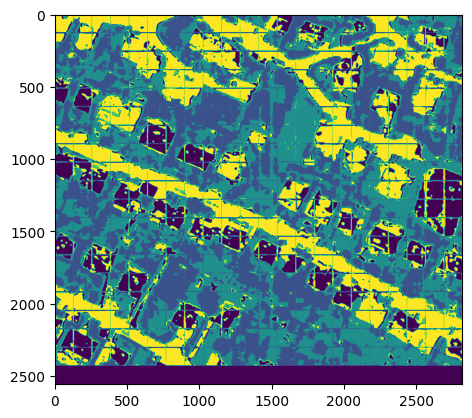

In [ ]:
# Construindo o caminho de volta à imagem inteira
reconstructed_image = np.zeros((2558, 2818))

# Reconstruir a imagem a partir dos patches de predição
for i, tupla in enumerate(sample_test):
    x, y = tupla
    patch = predicted_labels[i]
    reconstructed_image[x*128:x*128+128, y*128:y*128+128] = patch

# Verificar a forma da imagem reconstruída
plt.imshow(reconstructed_image)

# 9. Compute Metrics

In [ ]:
enc = LabelEncoder()
true_labels = np.array(tf.image.rgb_to_grayscale(np.transpose(test_ref_img, (1, 2, 0))))
true_labels = enc.fit_transform(true_labels.flatten()).reshape(true_labels.shape).squeeze()


compute_metrics(true_labels.flatten(), reconstructed_image.flatten())

(57.86864682586145,
 array([48.81258318, 66.0421029 , 57.26444758, 27.79499716, 56.37429084]),
 array([50.01627304, 61.98914707, 52.04307082, 23.54485615, 72.35737717]),
 array([47.66546771, 70.66211193, 63.65036039, 33.91753676, 46.17471613]))